In [1]:
from IPython.display import Image
from IPython.core.display import HTML

# Lesson 2: Introduction to spikes and model optimization

## Lesson goals:

1. Discuss solutions to two challenges from Lesson 1:
 - Write a function to measure the "input resistance" of a neuron compartment
 - Organize recordings and superimpose results from multiple simulations
2. Introduction to sodium and potassium channels involved in generating action potentials (spikes)
3. Introduction to NMODL, the language used to specify ion channel mechanisms in NEURON
4. Inserting "Hodgkin-Huxley" ion channels into a NEURON model compartment
5. Plotting the voltage-dependence of the sodium and potassium channel "gates"
6. Introduction to function optimization with scipy.optimize
7. Perform bounded parameter optimization on the input resistance of a NEURON section

## Challenge:

8. Measure and plot an "f-I curve"
9. Vary parameters of the spiking mechanisms and optimize the slope of the f-I curve.

## 1. Discuss solutions to two challenges from Lesson 1:

### Write a function to measure the "input resistance" of a neuron compartment

In [2]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from neuron import h
h.load_file('stdrun.hoc')

1.0

In [9]:
def get_input_resistance(t, vm, i, start, stop, window_dur):
    
    baseline_start_index = np.where(t >= start - window_dur)[0][0]
    baseline_end_index = np.where(t >= start)[0][0]
    equil_start_index = np.where(t >= stop - window_dur)[0][0]
    equil_end_index = np.where(t >= stop)[0][0]
    delta_vm = np.abs(np.mean(vm[equil_start_index:equil_end_index]) - np.mean(vm[baseline_start_index:baseline_end_index]))
    delta_i = np.abs(np.mean(i[equil_start_index:equil_end_index]) - np.mean(i[baseline_start_index:baseline_end_index]))
    
    # Ohms = Volts / Amps; MegaOhms = milliVolts / nanoAmps
    input_res = delta_vm / delta_i
    return input_res

In [21]:
soma = h.Section()
soma.L = 20.
soma.diam = 20.

soma.insert('pas')
leak_mechanism = soma(0.5).pas
pas_g0 = 0.0005
leak_mechanism.g = pas_g0  # conductance of leak channel in microSeimens
v_init = -65.
pas_e0 = v_init
leak_mechanism.e = pas_e0

t = h.Vector()
soma_voltage = h.Vector()
t.record(h._ref_t)  # record the time stamp
soma_voltage.record(soma(0.5)._ref_v)  # record the voltage across the membrane in a segment

step_current_stim = h.IClamp(soma(0.5))
step_current_stim.amp = -0.1  # amplitude in nanoAmps
step_current_stim.dur = 200.  # duration in milliseconds
step_current_stim.delay = 200.  # start time of current injection

step_current_rec = h.Vector()
step_current_rec.record(step_current_stim._ref_i)

h.tstop = 600.

<IPython.core.display.Javascript object>


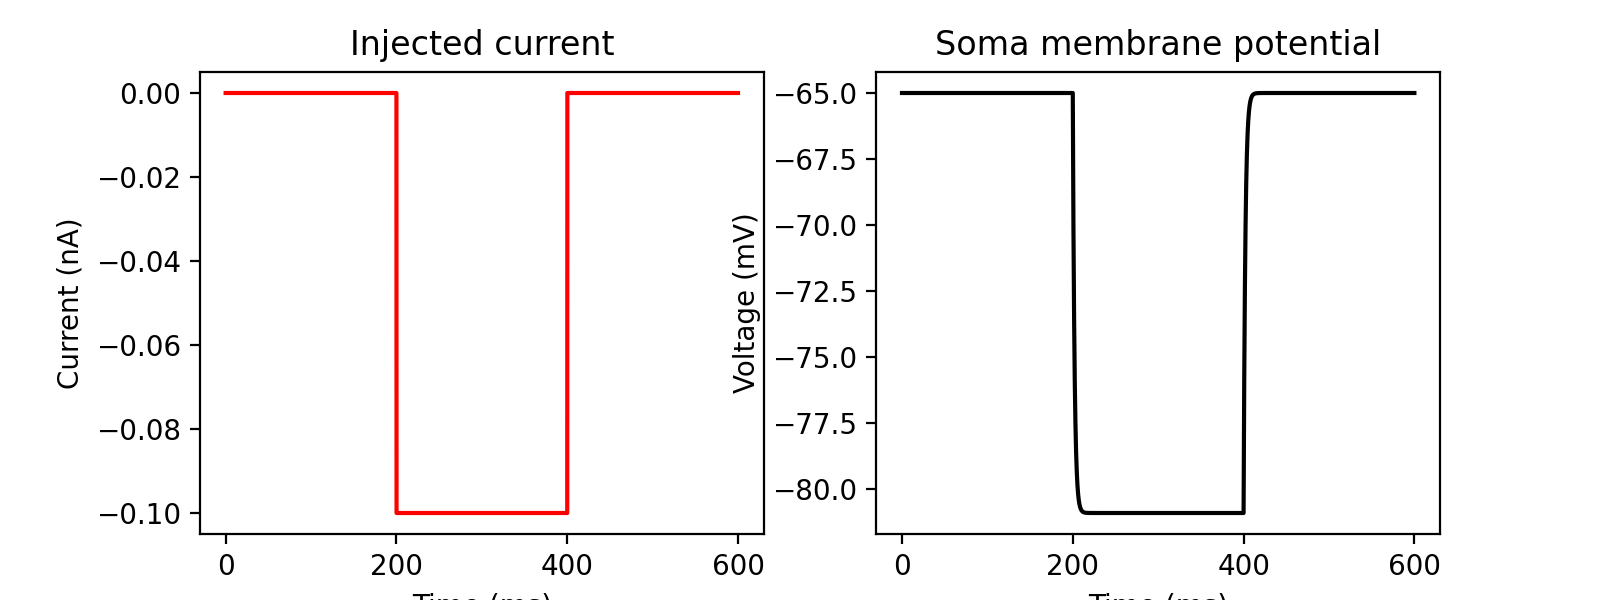

The input resistance is 159.15 MOhm


In [22]:
h.run(v_init)

fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].plot(t, step_current_rec, c='r')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Current (nA)')
axes[0].set_title('Injected current')
axes[1].plot(t, soma_voltage, c='k')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Voltage (mV)')
axes[1].set_title('Soma membrane potential')

input_resistance = get_input_resistance(np.array(t), np.array(soma_voltage), np.array(step_current_rec), start=200., stop=400., window_dur=10.)
print('The input resistance is %.2f MOhm' % input_resistance)

### Organize recordings and superimpose results from multiple simulations

In [23]:
sim_history = []
stim_amp_array = np.arange(0., 0.6, 0.1)

for stim_amp in stim_amp_array:
    sim_record = {}
    sim_record['stim_amp'] = stim_amp
    step_current_stim.amp = stim_amp
    sim_record['description'] = '%.1f nA' % stim_amp
    h.run(v_init)
    sim_record['soma_voltage'] = np.array(soma_voltage)
    sim_record['t'] = np.array(t)
    sim_record['step_current_rec'] = np.array(step_current_rec)
    
    sim_history.append(sim_record)

<IPython.core.display.Javascript object>


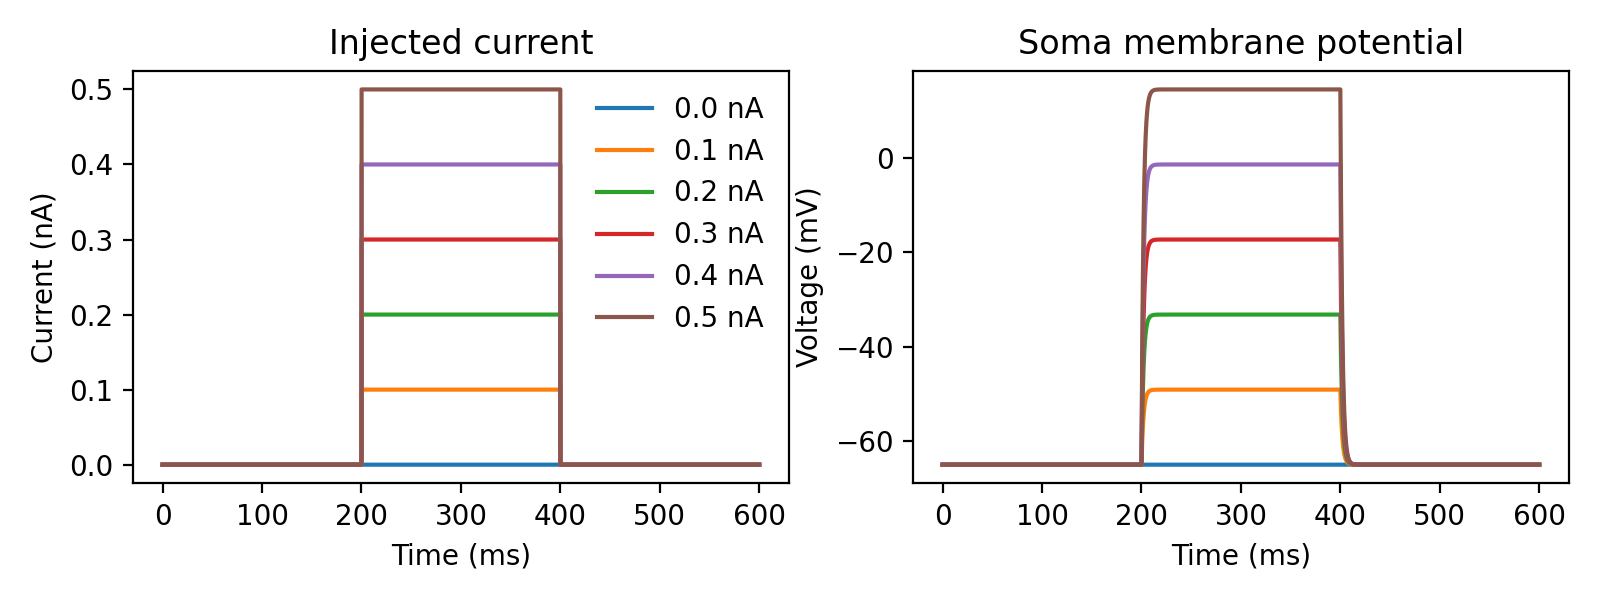

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))

for sim_record in sim_history:
    t_array = sim_record['t']
    soma_voltage_array = sim_record['soma_voltage']
    step_current_rec_array = sim_record['step_current_rec']
    description = sim_record['description']
    axes[0].plot(t_array, step_current_rec_array, label=description)
    axes[0].set_xlabel('Time (ms)')
    axes[0].set_ylabel('Current (nA)')
    axes[0].set_title('Injected current')
    axes[1].plot(t_array, soma_voltage_array)
    axes[1].set_xlabel('Time (ms)')
    axes[1].set_ylabel('Voltage (mV)')
    axes[1].set_title('Soma membrane potential')
axes[0].legend(loc='best', frameon=False)
fig.tight_layout(w_pad=0.2)

## 2. Introduction to sodium and potassium channels involved in generating action potentials (spikes)

<img src="images/hh_fig1.jpg" width="1000">

### Great resource:

https://ocw.mit.edu/courses/brain-and-cognitive-sciences/9-40-introduction-to-neural-computation-spring-2018/lecture-notes/MIT9_40S18_Lec04.pdf

## 3. Introduction to NMODL, the language used to specify ion channel mechanisms in NEURON

Earlier we inserted the ion channel mechanism 'pas' into our NEURON model to provide a passive "leak" current.

Now we want to insert sodium and potassium ion channels to allow our model to generate spikes.

Let's look at the code that describes the time- and voltage-dependent activation and inactivation of these channels:

Here are the contents of the built-in NEURON mechanism defined in 'hh.mod':

    TITLE hh.mod   squid sodium, potassium, and leak channels

    COMMENT
     This is the original Hodgkin-Huxley treatment for the set of sodium, 
      potassium, and leakage channels found in the squid giant axon membrane.
      ("A quantitative description of membrane current and its application 
      conduction and excitation in nerve" J.Physiol. (Lond.) 117:500-544 (1952).)
     Membrane voltage is in absolute mV and has been reversed in polarity
      from the original HH convention and shifted to reflect a resting potential
      of -65 mV.
     Remember to set celsius=6.3 (or whatever) in your HOC file.
     See squid.hoc for an example of a simulation using this model.
     SW Jaslove  6 March, 1992
    ENDCOMMENT

    UNITS {
            (mA) = (milliamp)
            (mV) = (millivolt)
        (S) = (siemens)
    }

    NEURON {
            SUFFIX hh
            USEION na READ ena WRITE ina
            USEION k READ ek WRITE ik
            NONSPECIFIC_CURRENT il
            RANGE gnabar, gkbar, gl, el, gna, gk
            GLOBAL minf, hinf, ninf, mtau, htau, ntau
    }

    PARAMETER {
            gnabar = .12 (S/cm2)	<0,1e9>
            gkbar = .036 (S/cm2)	<0,1e9>
            gl = .0003 (S/cm2)	<0,1e9>
            el = -54.3 (mV)
    }

    STATE {
            m h n
    }

    ASSIGNED {
            v (mV)
            celsius (degC)
            ena (mV)
            ek (mV)

        gna (S/cm2)
        gk (S/cm2)
            ina (mA/cm2)
            ik (mA/cm2)
            il (mA/cm2)
            minf hinf ninf
        mtau (ms) htau (ms) ntau (ms)
    }
    
    BREAKPOINT {
            SOLVE states METHOD cnexp
            gna = gnabar*m*m*m*h
        ina = gna*(v - ena)
            gk = gkbar*n*n*n*n
        ik = gk*(v - ek)      
            il = gl*(v - el)
    }


    INITIAL {
        rates(v)
        m = minf
        h = hinf
        n = ninf
    }
    
    DERIVATIVE states {  
            rates(v)
            m' =  (minf-m)/mtau
            h' = (hinf-h)/htau
            n' = (ninf-n)/ntau
    }

    :LOCAL q10

    
    PROCEDURE rates(v(mV)) {  :Computes rate and other constants at current v.
                          :Call once from HOC to initialize inf at resting v.
            LOCAL  alpha, beta, sum, q10
            TABLE minf, mtau, hinf, htau, ninf, ntau DEPEND celsius FROM -100 TO 100 WITH 200

    UNITSOFF
            q10 = 3^((celsius - 6.3)/10)
                    :"m" sodium activation system
            alpha = .1 * vtrap(-(v+40),10)
            beta =  4 * exp(-(v+65)/18)
            sum = alpha + beta
        mtau = 1/(q10*sum)
            minf = alpha/sum
                    :"h" sodium inactivation system
            alpha = .07 * exp(-(v+65)/20)
            beta = 1 / (exp(-(v+35)/10) + 1)
            sum = alpha + beta
        htau = 1/(q10*sum)
            hinf = alpha/sum
                    :"n" potassium activation system
            alpha = .01*vtrap(-(v+55),10) 
            beta = .125*exp(-(v+65)/80)
        sum = alpha + beta
            ntau = 1/(q10*sum)
            ninf = alpha/sum
    }

    FUNCTION vtrap(x,y) {  :Traps for 0 in denominator of rate eqns.
            if (fabs(x/y) < 1e-6) {
                    vtrap = y*(1 - x/y/2)
            }else{
                    vtrap = x/(exp(x/y) - 1)
            }
    }

    UNITSON

### First we need a default NEURON section, which mimics Hodgkin-Huxley's conditions:

In [30]:
soma = h.Section()

soma.insert('hh')

t = h.Vector()
soma_voltage = h.Vector()
t.record(h._ref_t)  # record the time stamp
soma_voltage.record(soma(0.5)._ref_v)  # record the voltage across the membrane in a segment

step_current_stim = h.IClamp(soma(0.5))
step_current_stim.amp = 10.  # amplitude in nanoAmps
step_current_stim.dur = 200.  # duration in milliseconds
step_current_stim.delay = 200.  # start time of current injection

step_current_rec = h.Vector()
step_current_rec.record(step_current_stim._ref_i)

h.tstop = 600.

### Let's make sure it spikes when we inject current (and not when we do not).

<IPython.core.display.Javascript object>


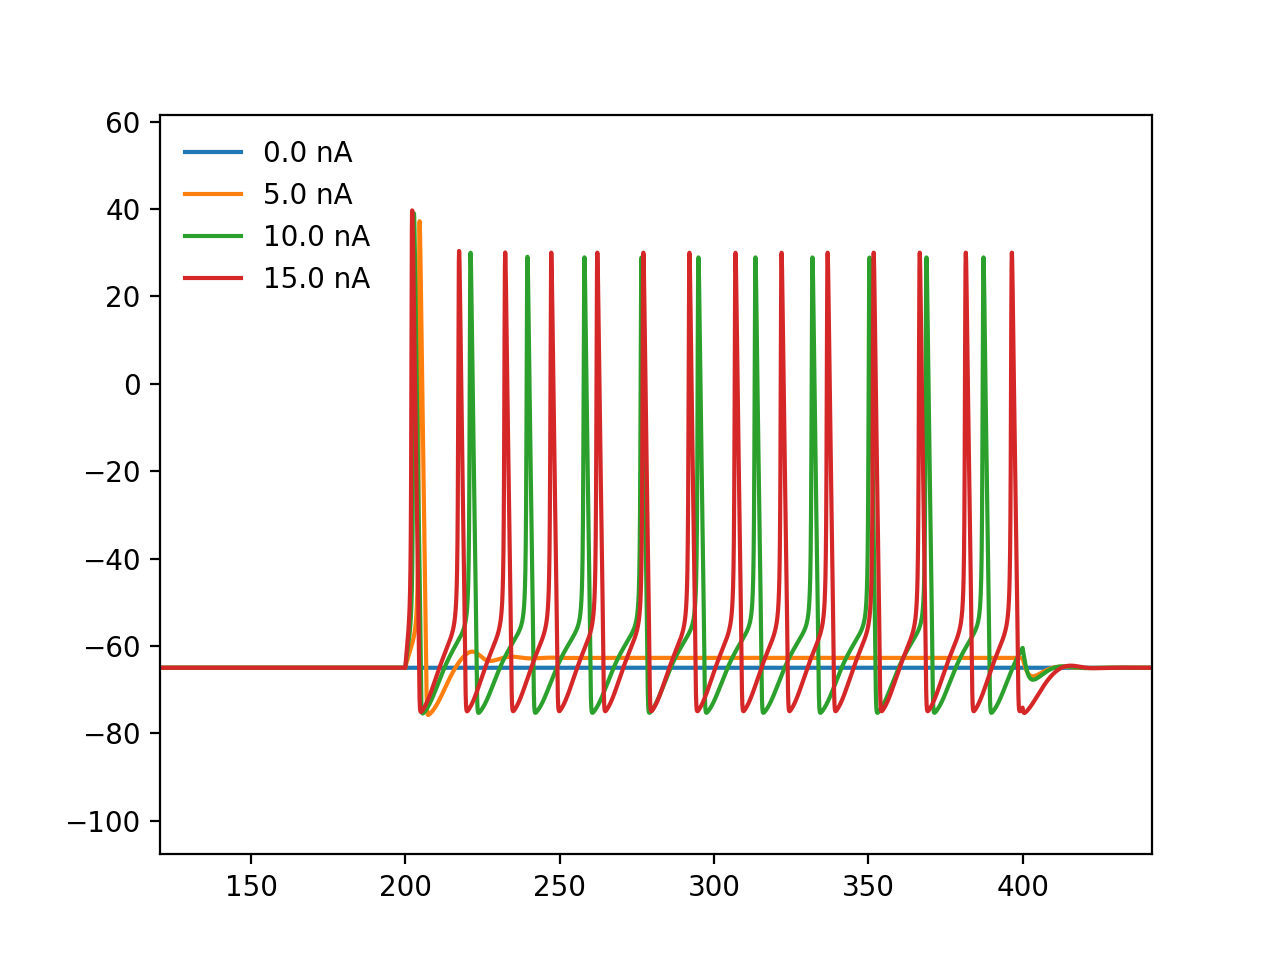

In [36]:
plt.figure()
for stim_amp in np.arange(0., 20., 5.):
    step_current_stim.amp = stim_amp
    h.run()
    plt.plot(t, soma_voltage, label='%.1f nA' % stim_amp)
plt.legend(loc='best', frameon=False)

### We can also record the actual currents through the sodium and potassium channels during a spike:

<IPython.core.display.Javascript object>


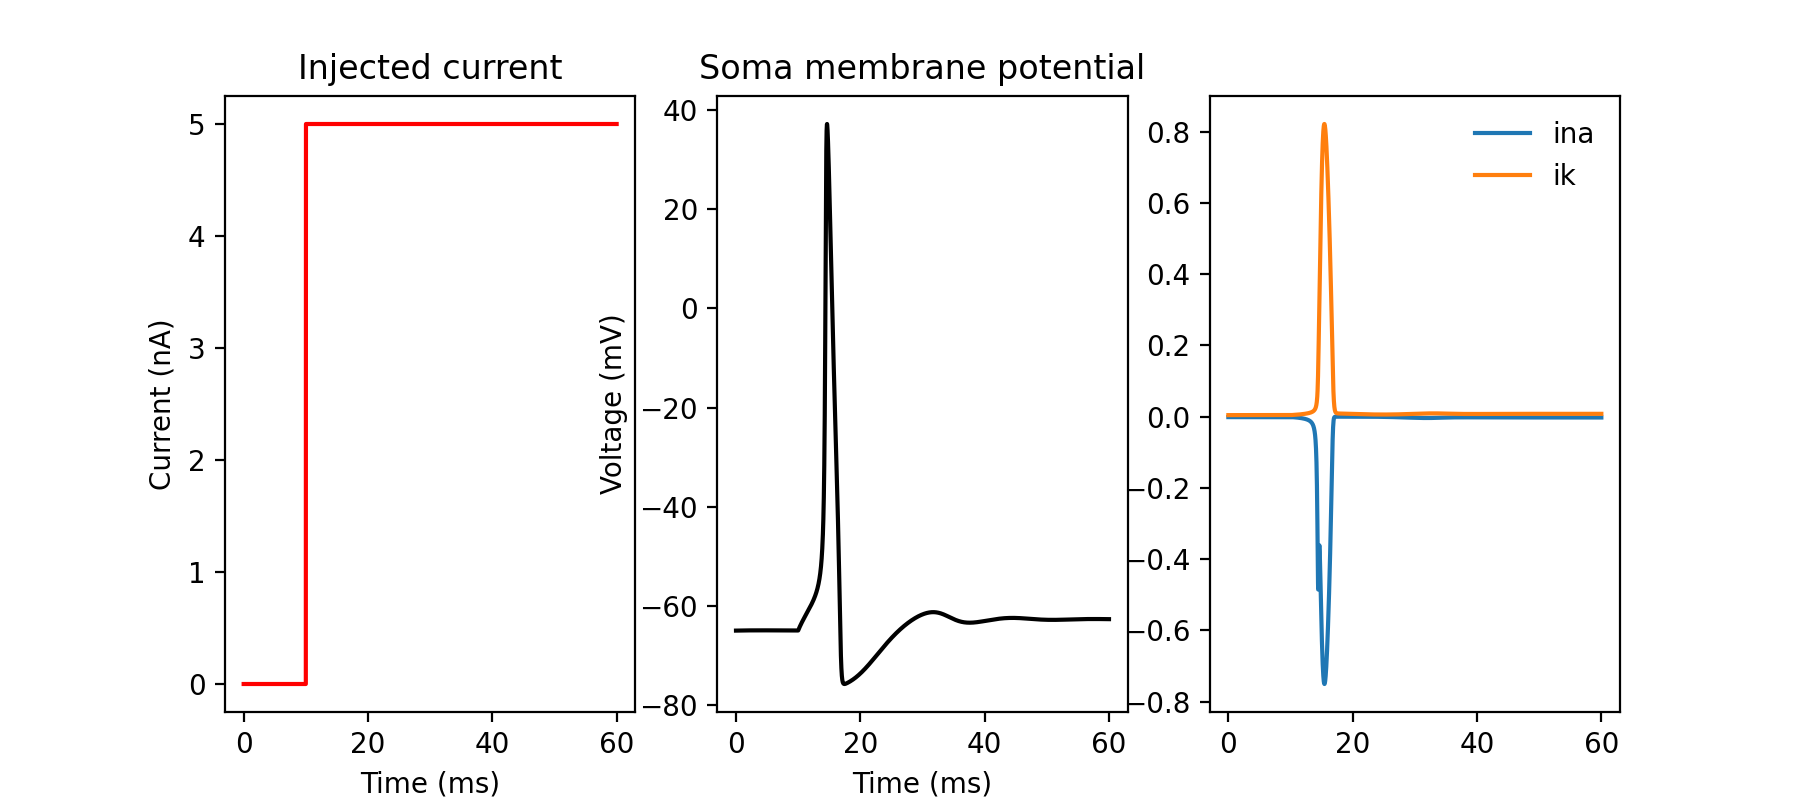

In [47]:
soma_ina_rec = h.Vector()
soma_ina_rec.record(soma(0.5)._ref_ina)

soma_ik_rec = h.Vector()
soma_ik_rec.record(soma(0.5)._ref_ik)

step_current_stim.amp = 5.
step_current_stim.delay = 10.
step_current_stim.dur = 50.
h.tstop = 60.
h.run()

fig, axes = plt.subplots(1, 3, figsize=(9, 4))
axes[0].plot(t, step_current_rec, c='r')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Current (nA)')
axes[0].set_title('Injected current')
axes[1].plot(t, soma_voltage, c='k')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Voltage (mV)')
axes[1].set_title('Soma membrane potential')
axes[2].plot(t, soma_ina_rec, label='ina')
axes[2].plot(t, soma_ik_rec, label='ik')
axes[2].legend(loc='best', frameon=False)


## 3. Introduction to function optimization with scipy.optimize

Resource: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

Let's say we have a function that takes an array of free parameters, and produces a single float output:

<IPython.core.display.Javascript object>


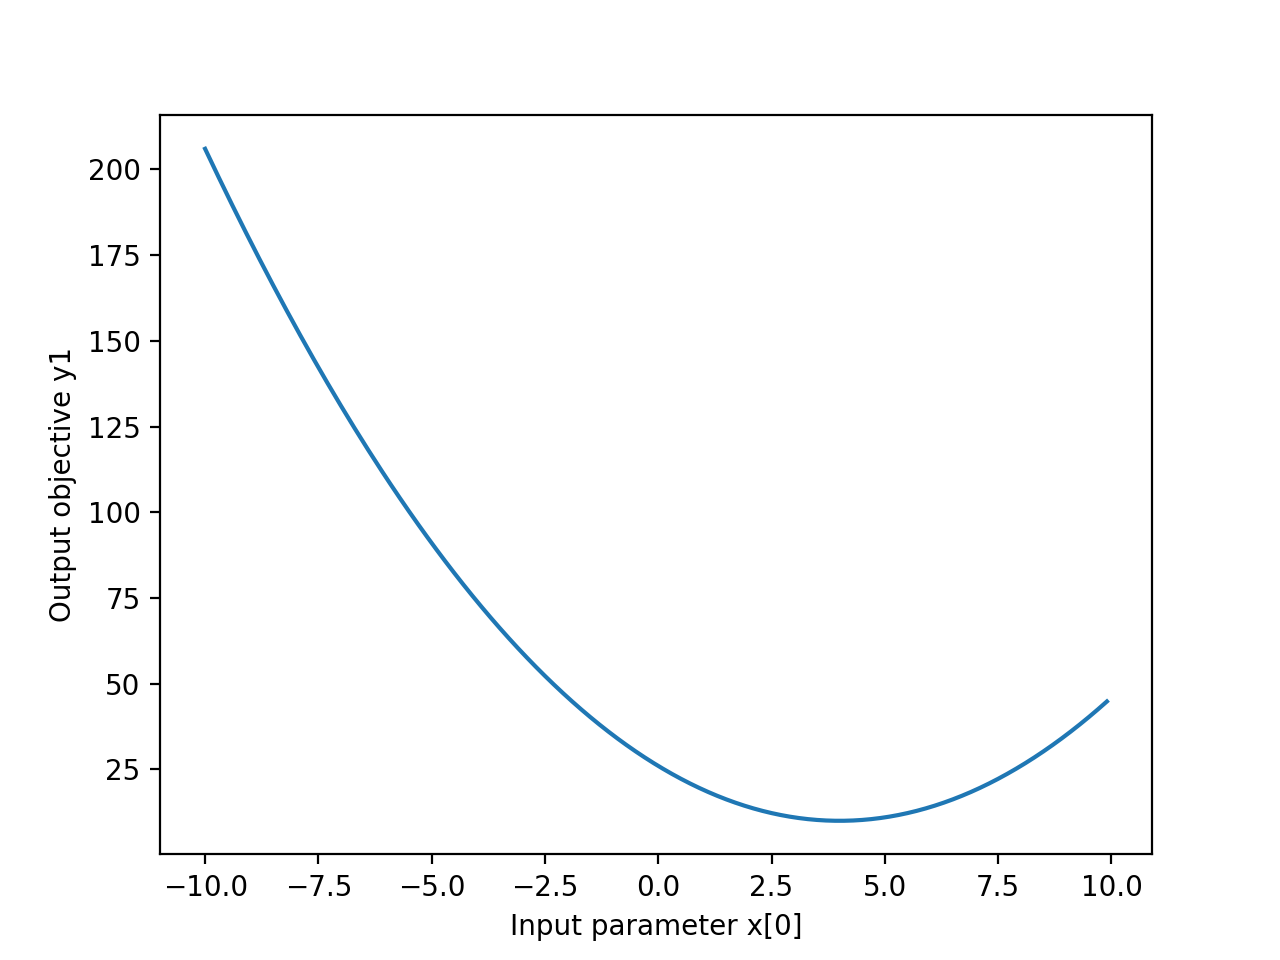

In [3]:
def y1(x):
    """
    The argument 'x' is an array of length 1.
    """
    y = (x[0] - 4) ** 2. + 10.
    return y

test_x = np.arange(-10., 10., 0.1)
test_y1 = [y1([xi]) for xi in test_x]
plt.figure()
plt.plot(test_x, test_y1)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y1')
plt.show()

Since this is a simple function, we could obtain the global minimum by graphing the function, or by solving the equation analytically. But when functions are complex, numerical optimization methods become useful tools to search for approximate local minimums.

scipy.optimize.minimize is a general interface that can use many different algorithms to search for input parameters that minimize a provided function. 

In [4]:
from scipy.optimize import minimize
# initial guess for the input parameter
x0 = 0.

result = minimize(y1, [x0], options={'disp': True})

Optimization terminated successfully.
         Current function value: 10.000000
         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 4


In [5]:
print(result)

      fun: 10.000000000000002
 hess_inv: array([[0.49999999]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([3.99999995])


Well that was easy. But how do we know what parameters it tested? We'll have to manually keep track by appending the values to a global variable:

Optimization terminated successfully.
         Current function value: 10.000000
         Iterations: 3
         Function evaluations: 12
         Gradient evaluations: 4


<IPython.core.display.Javascript object>


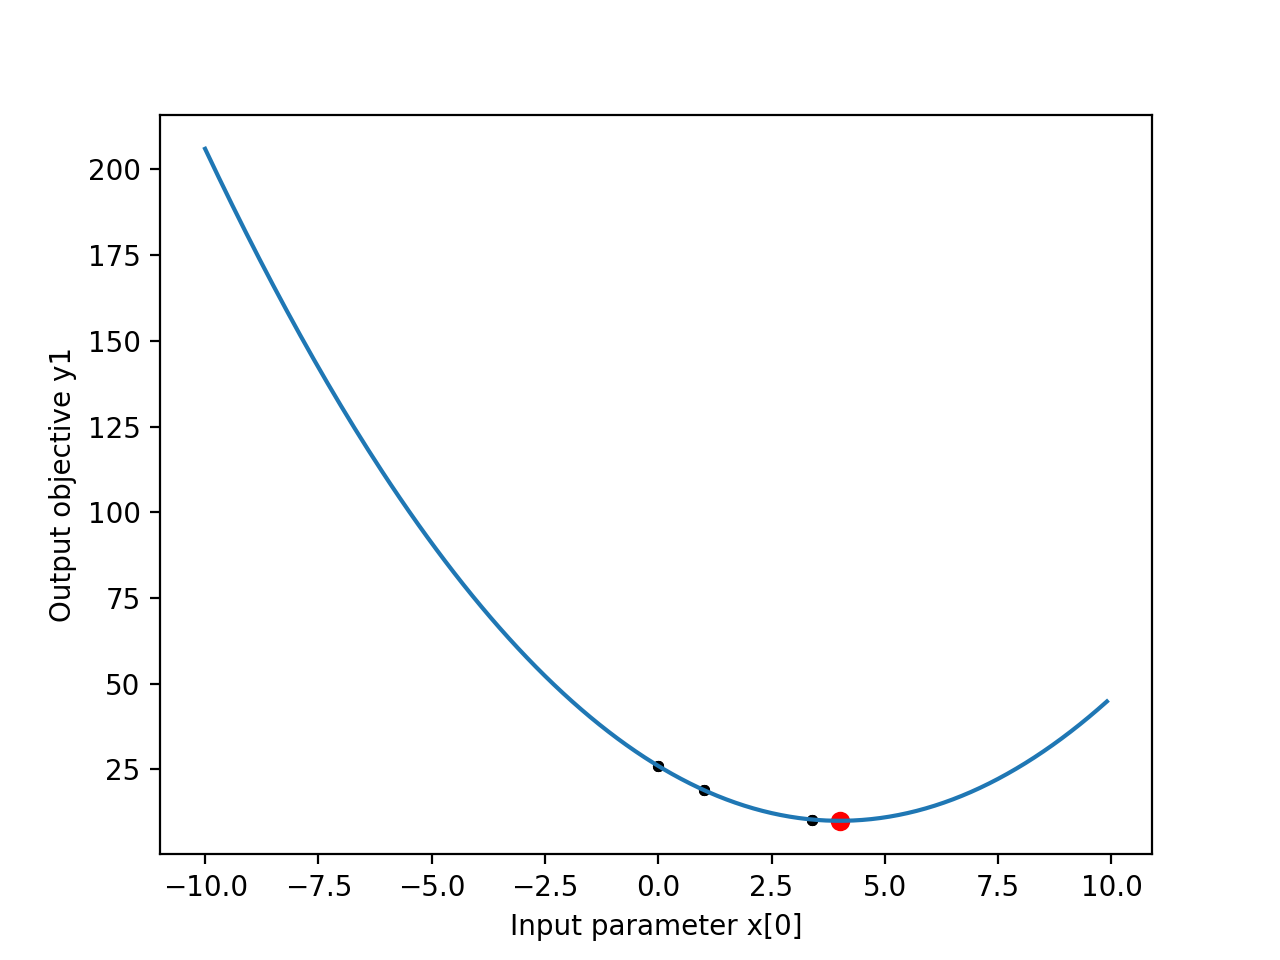

[3.99999995] 10.000000000000002


In [6]:
x_history = []
y_history = []

def y1(x):
    """
    The argument 'x' is an array of length 1.
    """
    x_history.append(x)
    y = (x[0] - 4) ** 2. + 10.
    y_history.append(y)
    return y

result = minimize(y1, [x0], options={'disp': True})

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], yi, marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y1)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y1')
plt.show()

print(result.x, result.fun)

What if there is no true global minimum?

In [7]:
def y2(x):
    """
    The argument 'x' is an array of length 1.
    """
    x_history.append(x)
    y = np.exp(-x[0])
    y_history.append(y)
    return y

test_y2 = [y2([xi]) for xi in test_x]

Optimization terminated successfully.
         Current function value: 0.000006
         Iterations: 17
         Function evaluations: 54
         Gradient evaluations: 18


<IPython.core.display.Javascript object>


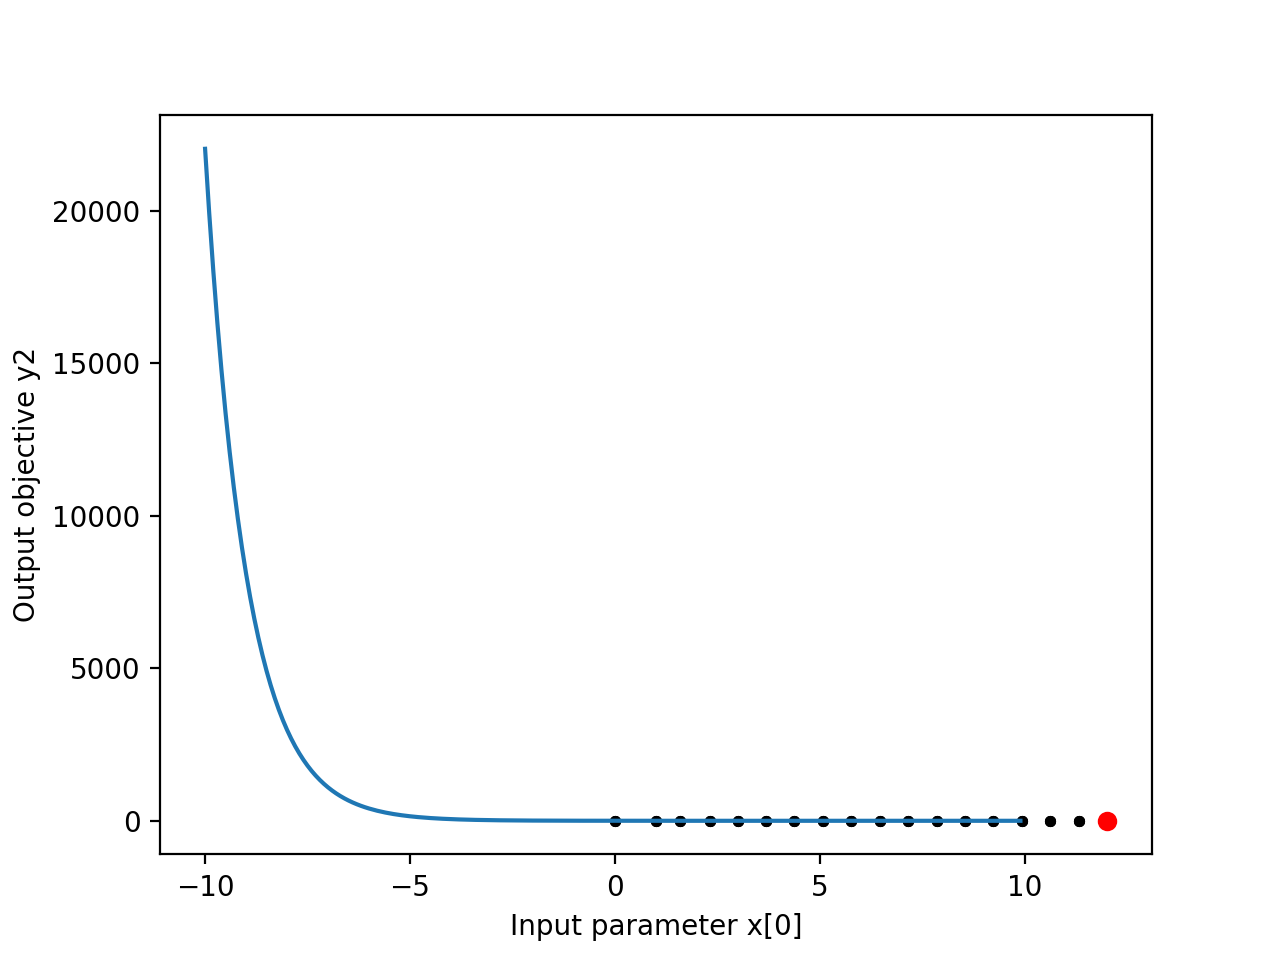

[12.01100351] 6.076975025331183e-06


In [8]:
x_history = []
y_history = []
result = minimize(y2, [x0], options={'disp': True})

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y2)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y2')
plt.show()

print(result.x, result.fun)

If there is no true global minimum, minimize will find a local one up to some error tolerance.

In [ ]:
x_history = []
y_history = []
result = minimize(y2, [x0], options={'disp': True}, tol=0.1)

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y2)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y2')
plt.show()

print(result.x, result.fun)

In [ ]:
x_history = []
y_history = []
result = minimize(y2, [x0], options={'disp': True}, tol=1e-12)

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y2)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y2')
plt.show()

print(result.x, result.fun)

What if the function has multiple local minima?

In [ ]:
def y3(x):
    """
    The argument 'x' is an array of length 1.
    """
    x_history.append(x)
    y = np.sin(x[0])
    y_history.append(y)
    return y

test_y3 = [y3([xi]) for xi in test_x]

In [ ]:
x_history = []
y_history = []
result = minimize(y3, [x0], options={'disp': True})

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y3)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y3')
plt.show()

print(result.x, result.fun)

If the function has multiple local minima, the search can be limited to a bounded range of parameters:

In [ ]:
x_history = []
y_history = []
result = minimize(y3, [x0], options={'disp': True}, method='L-BFGS-B', bounds=((-1., 10.),))

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y3)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y3')
plt.show()

print(result.x, result.fun)

So gradient-based approaches do not always find the desired local minimum! Let's try a non-gradient-based algorithm:

In [ ]:
x_history = []
y_history = []
result = minimize(y3, [x0], options={'disp': True}, method='Nelder-Mead', bounds=((-1., 10.),))

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y3)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y3')
plt.show()

print(result.x, result.fun)

But this algorithm does not respect bounds. We can manually implement them by hard coding our function to be optimized to return a very large error value when parameters are out of bounds:

In [ ]:
def y3(x):
    """
    The argument 'x' is an array of length 1.
    """
    for xi, bi in zip(x, bounds):
        if not bi[0] <= xi <= bi[1]:
            return 1e9
    x_history.append(x)
    y = np.sin(x[0])
    y_history.append(y)
    return y

In [9]:
x_history = []
y_history = []
bounds=((-1., 10.),)

result = minimize(y3, [x0], options={'disp': True}, method='Nelder-Mead')

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y3)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y3')
plt.ylim((-2., 2.))
plt.show()

print(result.x, result.fun)

NameError: name 'y3' is not defined

This algorithm, also known as "Simplex", only wants to look locally. It's a good "polisher", but we need a better way to search the whole bounded range. "Basinhopping" or "Simulated annealing" is good for this:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html#scipy.optimize.basinhopping

In every iteration, this algorithm will generate new parameters by taking "steps" from a previously visited point in the parameter space. Then it will try to use a local minimizer to polish the result. The initial stepsize can be specified, and with every iteration, the "temperature" decreases, which reduces the stepsize and decreases the error tolerance.

In [10]:
from scipy.optimize import basinhopping

In [ ]:
x_history = []
y_history = []
bounds=((-1., 10.),)

stepsize = 0.5 * (bounds[0][1] - bounds[0][0])

result = basinhopping(y3, [x0], minimizer_kwargs={'method': 'Nelder-Mead'}, stepsize=stepsize, disp=True)

plt.figure()
for xi, yi in zip(x_history, y_history):
    plt.scatter(xi[0], [yi], marker='.', c='k')
plt.scatter(result.x[0], result.fun, marker='o', c='r')
plt.plot(test_x, test_y3)
plt.xlabel('Input parameter x[0]')
plt.ylabel('Output objective y3')
plt.ylim((-2., 2.))
plt.show()

print(result.x, result.fun)

## 4. Perform bounded parameter optimization on the input resistance of a NEURON section

In [11]:
from neuron import h
h.load_file('stdrun.hoc')

1.0

In [12]:
soma = h.Section()
soma.L = 20.
soma.diam = 20.
soma.insert('pas')

soma_pas_g0 = soma(0.5).pas.g

h.tstop = 400.
v_init = -65.
h.v_init = v_init
soma(0.5).pas.e = v_init

t = h.Vector()
soma_voltage = h.Vector()
t.record(h._ref_t, h.dt)  # record the time base
soma_voltage.record(soma(0.5)._ref_v, h.dt)  # record the voltage across the membrane in a segment

step_current_stim = h.IClamp(soma(0.5))
step_current_stim.amp = -0.05  # amplitude in nanoAmps
step_current_stim.dur = 200.  # duration in milliseconds
step_current_stim.delay = 200.  # start time of current injection

In [13]:
def get_R_inp(t, v, i_amp, baseline_window=(195., 200.),  measurement_window=(395., 400.)):
    baseline_indexes = np.where((baseline_window[0] <= t) & (t < baseline_window[1]))
    measurement_indexes = np.where((measurement_window[0] <= t) & (t < measurement_window[1]))
    baseline_v = np.mean(v[baseline_indexes])
    measurement_v = np.mean(v[measurement_indexes])
    delta_v = abs(baseline_v - measurement_v)
    R_inp = (delta_v / 1000.) / (abs(i_amp) / 1e9) / 1e6 # convert mV to V, nA to A, and Ohm to MegaOhm
    return R_inp

def get_soma_R_inp_error(x, target, bounds, sim_history):
    for xi, bi in zip(x, bounds):
        if not bi[0] <= xi <= bi[1]:
            return 1e9
    soma(0.5).pas.g = x[0]
    h.run()
    t_array = np.array(t)
    v_array = np.array(soma_voltage)
    i_amp = step_current_stim.amp
    soma_R_inp = get_R_inp(t_array, v_array, i_amp)
    error = (target - soma_R_inp) ** 2.
    this_sim_summary = {}
    this_sim_summary['t'] = t_array
    this_sim_summary['soma_voltage'] = v_array
    this_sim_summary['soma_R_inp'] = soma_R_inp
    this_sim_summary['error'] = error
    sim_history[tuple(x)] = this_sim_summary
    
    return error

In [14]:
bounds = ((1e-12, 0.1),)
stepsize = 0.5 * (bounds[0][1] - bounds[0][0])
x0 = [soma_pas_g0]
target_soma_R_inp = 150.

sim_history = {} # {x0: {'t': array, 'soma_voltage': array, 'soma_R_inp': float, 'error': float}

result = basinhopping(get_soma_R_inp_error, x0, stepsize=stepsize, disp=True, 
                     minimizer_kwargs={'method': 'Nelder-Mead', 'args': (target_soma_R_inp, bounds, sim_history)})

basinhopping step 0: f 0.000182134
basinhopping step 1: f 2.72438e-05 trial_f 2.72438e-05 accepted 1  lowest_f 2.72438e-05
found new global minimum on step 1 with function value 2.72438e-05
basinhopping step 2: f 2.72438e-05 trial_f 1e+09 accepted 0  lowest_f 2.72438e-05
basinhopping step 3: f 2.72438e-05 trial_f 1e+09 accepted 0  lowest_f 2.72438e-05
basinhopping step 4: f 0.000140413 trial_f 0.000140413 accepted 1  lowest_f 2.72438e-05
basinhopping step 5: f 4.06986e-06 trial_f 4.06986e-06 accepted 1  lowest_f 4.06986e-06
found new global minimum on step 5 with function value 4.06986e-06
basinhopping step 6: f 4.06986e-06 trial_f 1e+09 accepted 0  lowest_f 4.06986e-06
basinhopping step 7: f 4.06986e-06 trial_f 1e+09 accepted 0  lowest_f 4.06986e-06
basinhopping step 8: f 3.26841e-05 trial_f 3.26841e-05 accepted 1  lowest_f 4.06986e-06
basinhopping step 9: f 3.26841e-05 trial_f 1e+09 accepted 0  lowest_f 4.06986e-06
basinhopping step 10: f 3.26841e-05 trial_f 1e+09 accepted 0  lowest_

basinhopping step 92: f 5.30274e-06 trial_f 5.30274e-06 accepted 1  lowest_f 4.97023e-07
basinhopping step 93: f 3.44088e-05 trial_f 3.44088e-05 accepted 1  lowest_f 4.97023e-07
basinhopping step 94: f 3.76709e-06 trial_f 3.76709e-06 accepted 1  lowest_f 4.97023e-07
basinhopping step 95: f 3.76709e-06 trial_f 1e+09 accepted 0  lowest_f 4.97023e-07
basinhopping step 96: f 3.76709e-06 trial_f 1e+09 accepted 0  lowest_f 4.97023e-07
basinhopping step 97: f 3.76709e-06 trial_f 1e+09 accepted 0  lowest_f 4.97023e-07
basinhopping step 98: f 3.76709e-06 trial_f 1e+09 accepted 0  lowest_f 4.97023e-07
basinhopping step 99: f 8.40285e-06 trial_f 8.40285e-06 accepted 1  lowest_f 4.97023e-07
adaptive stepsize: acceptance rate 0.510000 target 0.500000 new stepsize 0.0617284 old stepsize 0.0555556
basinhopping step 100: f 8.40285e-06 trial_f 1e+09 accepted 0  lowest_f 4.97023e-07


In [15]:
print(result)

                        fun: 4.970230626899677e-07
 lowest_optimization_result:  final_simplex: (array([[0.00053052],
       [0.00053049]]), array([4.97023063e-07, 5.22759721e-05]))
           fun: 4.970230626899677e-07
       message: 'Optimization terminated successfully.'
          nfev: 54
           nit: 27
        status: 0
       success: True
             x: array([0.00053052])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 3215
                        nit: 100
                          x: array([0.00053052])


<IPython.core.display.Javascript object>


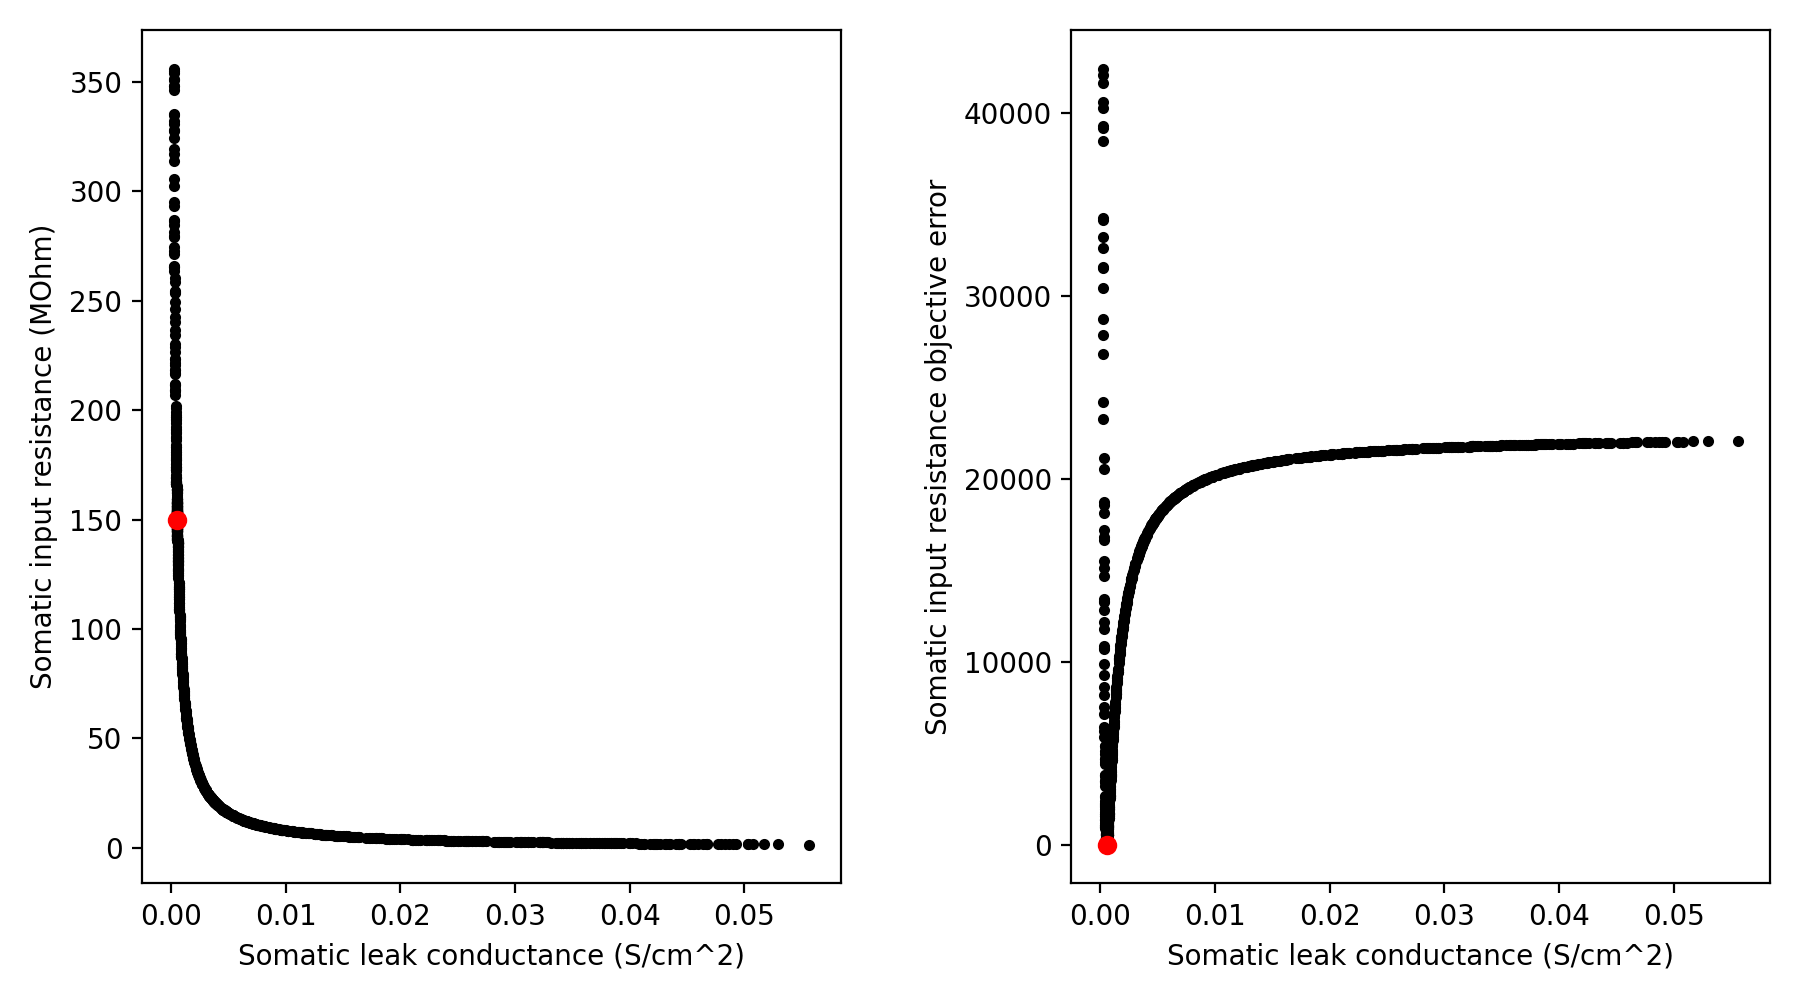

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(9., 5.))
for xi, this_sim_summary in sim_history.items():
    axes[0].scatter(xi[0], this_sim_summary['soma_R_inp'], marker='.', c='k')
    axes[1].scatter(xi[0], this_sim_summary['error'], marker='.', c='k')
axes[0].scatter(result.x[0], sim_history[tuple(result.x)]['soma_R_inp'], marker='o', c='r')
axes[1].scatter(result.x[0], result.fun, marker='o', c='r')
axes[0].set_xlabel('Somatic leak conductance (S/cm^2)')
axes[1].set_xlabel('Somatic leak conductance (S/cm^2)')
axes[0].set_ylabel('Somatic input resistance (MOhm)')
axes[1].set_ylabel('Somatic input resistance objective error')
fig.tight_layout(w_pad=3.)
fig.show()

optimal_pas_g = result.x[0]

## 5. Introduction to NMODL, the language used to specify ion channel mechanisms in NEURON

Here are the contents of the built-in NEURON mechanism defined in 'hh.mod':

    TITLE hh.mod   squid sodium, potassium, and leak channels

    COMMENT
     This is the original Hodgkin-Huxley treatment for the set of sodium, 
      potassium, and leakage channels found in the squid giant axon membrane.
      ("A quantitative description of membrane current and its application 
      conduction and excitation in nerve" J.Physiol. (Lond.) 117:500-544 (1952).)
     Membrane voltage is in absolute mV and has been reversed in polarity
      from the original HH convention and shifted to reflect a resting potential
      of -65 mV.
     Remember to set celsius=6.3 (or whatever) in your HOC file.
     See squid.hoc for an example of a simulation using this model.
     SW Jaslove  6 March, 1992
    ENDCOMMENT

    UNITS {
            (mA) = (milliamp)
            (mV) = (millivolt)
        (S) = (siemens)
    }

    NEURON {
            SUFFIX hh
            USEION na READ ena WRITE ina
            USEION k READ ek WRITE ik
            NONSPECIFIC_CURRENT il
            RANGE gnabar, gkbar, gl, el, gna, gk
            GLOBAL minf, hinf, ninf, mtau, htau, ntau
    }

    PARAMETER {
            gnabar = .12 (S/cm2)	<0,1e9>
            gkbar = .036 (S/cm2)	<0,1e9>
            gl = .0003 (S/cm2)	<0,1e9>
            el = -54.3 (mV)
    }

    STATE {
            m h n
    }

    ASSIGNED {
            v (mV)
            celsius (degC)
            ena (mV)
            ek (mV)

        gna (S/cm2)
        gk (S/cm2)
            ina (mA/cm2)
            ik (mA/cm2)
            il (mA/cm2)
            minf hinf ninf
        mtau (ms) htau (ms) ntau (ms)
    }
    
    BREAKPOINT {
            SOLVE states METHOD cnexp
            gna = gnabar*m*m*m*h
        ina = gna*(v - ena)
            gk = gkbar*n*n*n*n
        ik = gk*(v - ek)      
            il = gl*(v - el)
    }


    INITIAL {
        rates(v)
        m = minf
        h = hinf
        n = ninf
    }
    
    DERIVATIVE states {  
            rates(v)
            m' =  (minf-m)/mtau
            h' = (hinf-h)/htau
            n' = (ninf-n)/ntau
    }

    :LOCAL q10

    
    PROCEDURE rates(v(mV)) {  :Computes rate and other constants at current v.
                          :Call once from HOC to initialize inf at resting v.
            LOCAL  alpha, beta, sum, q10
            TABLE minf, mtau, hinf, htau, ninf, ntau DEPEND celsius FROM -100 TO 100 WITH 200

    UNITSOFF
            q10 = 3^((celsius - 6.3)/10)
                    :"m" sodium activation system
            alpha = .1 * vtrap(-(v+40),10)
            beta =  4 * exp(-(v+65)/18)
            sum = alpha + beta
        mtau = 1/(q10*sum)
            minf = alpha/sum
                    :"h" sodium inactivation system
            alpha = .07 * exp(-(v+65)/20)
            beta = 1 / (exp(-(v+35)/10) + 1)
            sum = alpha + beta
        htau = 1/(q10*sum)
            hinf = alpha/sum
                    :"n" potassium activation system
            alpha = .01*vtrap(-(v+55),10) 
            beta = .125*exp(-(v+65)/80)
        sum = alpha + beta
            ntau = 1/(q10*sum)
            ninf = alpha/sum
    }

    FUNCTION vtrap(x,y) {  :Traps for 0 in denominator of rate eqns.
            if (fabs(x/y) < 1e-6) {
                    vtrap = y*(1 - x/y/2)
            }else{
                    vtrap = x/(exp(x/y) - 1)
            }
    }

    UNITSON

This mechanism specifies 3 distinct ion channels in one!
 - Passive leak conductance
 - Hodkin-Huxley-style sodium conductance with voltage-dependent activation gate and voltage-dependent inactivation gate
 - Hodkin-Huxley-style delayed rectifier potassium conductance with voltage-dependent activation gate
 
## Exercise: Let's plot the voltage dependence of the "m", "h", and "n" gates:
 - Use the rates(v) function defined in the .mod file to create python functions that plot minf, hinf, and ninf as functions of v

In [ ]:
q10 = 1.  # For this purpose, temperature = 6.3 and the temperature sensitivity factor = 1.

def vtrap(x, y):
    if abs(x/y) < 1e-6:
        return y * (1. - x / y / 2.)
    else:
        return x / (np.exp(x / y) - 1.)

In [ ]:
def mtau(v):
    alpha = .1 * vtrap(-(v+40), 10)
    beta =  4 * np.exp(-(v+65)/18)
    this_sum = alpha + beta
    return 1. / (q10 * this_sum)

def minf(v):
    alpha = .1 * vtrap(-(v+40), 10)
    beta =  4 * np.exp(-(v+65)/18)
    this_sum = alpha + beta
    return alpha / this_sum

def htau(v):
    # fill in
    return

def hinf(v):
    # fill in
    return

def ntau(v):
    # fill in
    return
    
def ninf(v):
    # fill in
    return

In [ ]:
v = np.arange(-100., 100., 0.1)

plt.figure()
plt.plot(v, minh(v))

If a function expects a float, you can pass in a vector and get back a vector if you wrap it with np.vectorize()!

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(9., 5.))
axes[0].plot(v, np.vectorize(mtau)(v))
axes[0].set_xlabel('Voltage (mV)')
axes[0].set_ylabel('Time constant (ms)')
axes[0].set_title('Na activation gate time constant')
axes[1].plot(v, np.vectorize(minf)(v))
axes[1].set_xlabel('Voltage (mV)')
axes[1].set_ylabel('Permeability factor')
axes[1].set_title('Na activation gate state')
fig.tight_layout(w_pad=3.)
fig.show()

In [ ]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(9., 5.))
axes[0].plot(v, np.vectorize(mtau)(v), label='Na activation')
axes[0].plot(v, np.vectorize(htau)(v), label='Na inactivation')
axes[0].set_xlabel('Voltage (mV)')
axes[0].set_ylabel('Time constant (ms)')
axes[0].set_title('Time constant')
axes[1].plot(v, np.vectorize(minf)(v), label='Na activation')
axes[1].plot(v, np.vectorize(hinf)(v), label='Na inactivation')
axes[1].set_xlabel('Voltage (mV)')
axes[1].set_ylabel('Permeability factor')
axes[1].set_title('State')
axes[0].legend(loc='best', frameon=False)
fig.tight_layout(w_pad=3.)
fig.show()

## 6. Insert "active" voltage-dependent "Hodgkin-Huxley" ion channels

In [ ]:
soma = h.Section()
soma.L = 20.
soma.diam = 20.
soma.insert('hh')

h.tstop = 600.
v_init = -65.
h.v_init = v_init

t = h.Vector()
soma_voltage = h.Vector()
t.record(h._ref_t, h.dt)  # record the time base
soma_voltage.record(soma(0.5)._ref_v, h.dt)  # record the voltage across the membrane in a segment

step_current_stim = h.IClamp(soma(0.5))
step_current_stim.amp = 0.1  # amplitude in nanoAmps
step_current_stim.dur = 200.  # duration in milliseconds
step_current_stim.delay = 200.  # start time of current injection

In [ ]:
h.run()
plt.figure()
plt.plot(t, soma_voltage)
plt.ylabel('Voltage (mV)')
plt.xlabel('Time (ms)')

In [ ]:
hh_mech = soma(0.5).hh

In [ ]:
hh_mech.   # tab to complete

Recordings can be established for the 3 ion channel conductances:

In [ ]:
gl = h.Vector()
gl.record(soma(0.5).hh._ref_gl, h.dt)
gna = h.Vector()
gna.record(soma(0.5).hh._ref_gna, h.dt)
gk = h.Vector()
gk.record(soma(0.5).hh._ref_gk, h.dt)

In [ ]:
h.run()
fig, axes = plt.subplots(2, sharex=True)
axes[0].plot(t, gl, label='gl')
axes[0].plot(t, gna, label='gna')
axes[0].plot(t, gk, label='gk')
axes[0].legend(loc='best', frameon=False)
axes[1].plot(t, soma_voltage, label='soma vm')
axes[1].legend(loc='best', frameon=False)
axes[0].set_ylabel('Conductance (S/cm^2)')
axes[1].set_ylabel('Voltage (mV)')
axes[1].set_xlabel('Time (ms)')

In [ ]:
gkbar0 = soma(0.5).hh.gkbar
gnabar0 = soma(0.5).hh.gnabar
gl0 = soma(0.5).hh.gl
T0 = h.celsius

In [ ]:
spike_times = h.Vector()
spike_detector = h.NetCon(soma(0.5)._ref_v, None, sec=soma)
spike_detector.delay = 0.  # ms
spike_detector.threshold = -10.  # mV
spike_detector.record(spike_times)

In [ ]:
step_current_stim.amp = 0.5
test_amp_vals = [0.05 * i for i in range(6)]
fig, axes = plt.subplots(len(test_amp_vals))
for i, amp in enumerate(test_amp_vals):
    step_current_stim.amp = amp
    h.run()
    print('Amp: %.2f;\nspike times: %s' % (amp, str(np.array(spike_times))))
    axes[i].plot(t, soma_voltage, label='Amp: %.2f;\nspike count: %i' % (amp, len(spike_times)))
    axes[i].legend(loc='best', frameon=False)
fig.show()

## 7. Challenge 1: Measure and plot an f-I curve

 - The relationship between input current (I) and output firing rate (f)
 - Make sure to only count spikes within the window of the step current injection

## 8. Challenge 2: Simultaneously optimize both somatic input resistance and the slope of the f-I curve.

 - Hint: x0 = [gl0, gnabar0, gkbar0]
 - How to construct a single error value that reflects 2 objectives?
 - Target f-I slope should be ~10 Hz / 0.05 nA
 - f-I slope should really only be calculated from values of I that produced more than one spike. ___/

Some papers to read for next week:

 - Stuart, Greg, and Nelson Spruston. "Determinants of voltage attenuation in neocortical pyramidal neuron dendrites." Journal of Neuroscience 18.10 (1998): 3501-3510. https://www.jneurosci.org/content/18/10/3501.full
 - Hoffman, Dax A., et al. "K+ channel regulation of signal propagation in dendrites of hippocampal pyramidal neurons." Nature 387.6636 (1997): 869-875. https://www.nature.com/articles/43119
 - Royeck, Michel, et al. "Role of axonal NaV1. 6 sodium channels in action potential initiation of CA1 pyramidal neurons." Journal of neurophysiology 100.4 (2008): 2361-2380.
 https://journals.physiology.org/doi/full/10.1152/jn.90332.2008